<a href="https://colab.research.google.com/github/MaryamAwad/FakeNewsDetection/blob/main/FakeNewsDetectionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
true = pd.read_csv('/content/drive/MyDrive/Fake-Real-News/True.csv')
fake = pd.read_csv('/content/drive/MyDrive/Fake-Real-News/Fake.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
#adding labels to every news article
true['label'] = 1
fake['label'] = 0

In [4]:
# Combine the sub-datasets in one. Use only the first 5000 articles in each to save time
frames = [true.loc[:5000][:], fake.loc[:5000][:]]
df = pd.concat(frames)
df.tail()

,title,text,subject,date,label
4996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016",0
4997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016",0
4998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016",0
4999,CNN Panelist LAUGHS In Corey Lewandowski’s Fa...,As Donald Trump s campaign continues to sink d...,News,"August 18, 2016",0
5000,Trump Supporter Who Wants To Shoot Black Kids...,"Hi folks, John Harper here, at least if you as...",News,"August 18, 2016",0


In [5]:
df['label'].value_counts()

1    5001
0    5001
Name: label, dtype: int64

In [6]:
df = df.dropna()
print(df.shape)

(10002, 5)


In [7]:
X = df.drop('label', axis=1)
y = df['label']
# Delete missing data
data = df.copy()
data.reset_index(inplace=True)

In [8]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

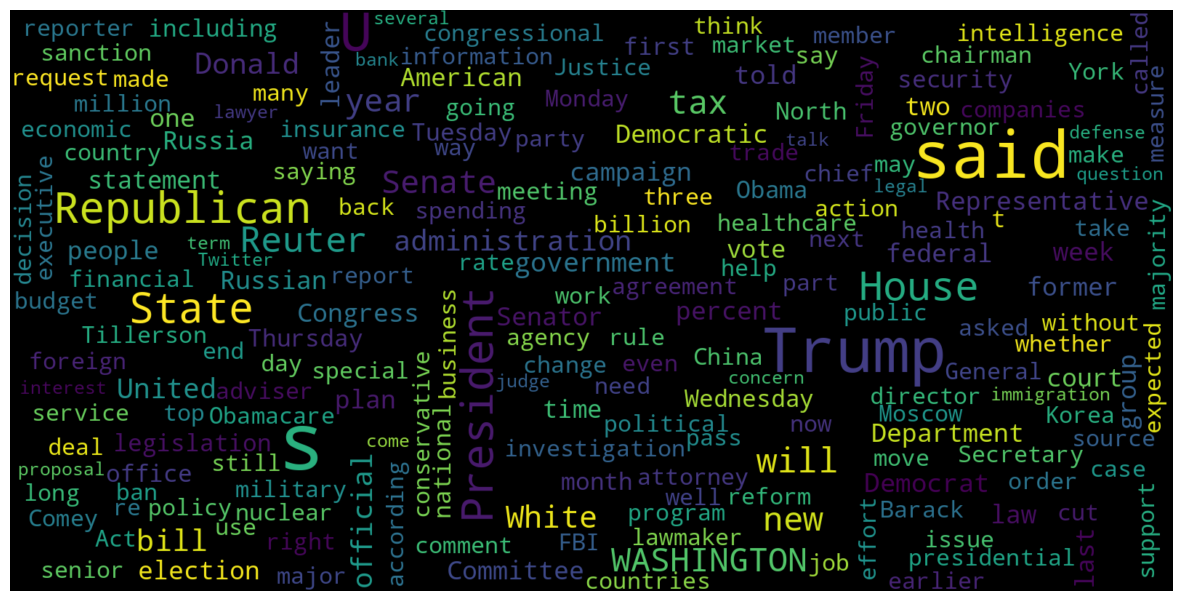

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
consolidated = ' '.join(
    word for word in data['text'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

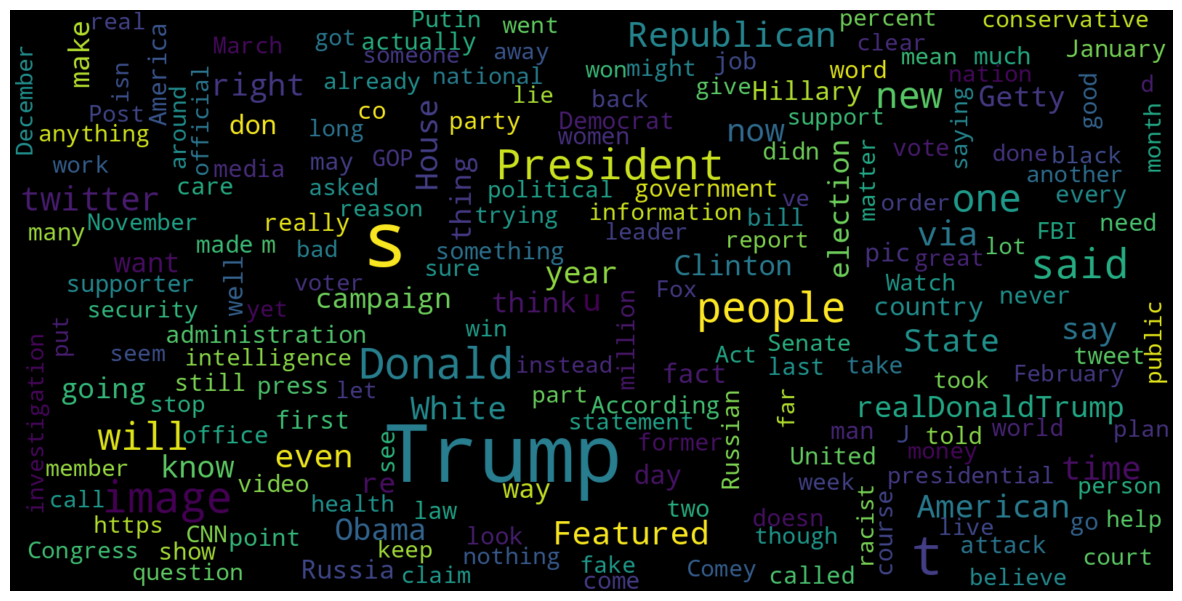

In [ ]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
features = data['text']
targets = data['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab = 10000
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(X_train)
#Convert text to vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
import tensorflow as tf
#pad the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [12]:
#model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 1382977 (5.28 MB)
Trainable params: 1382977 (5.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/5
240/240 [==============================] - 103s 406ms/step - loss: 0.1576 - accuracy: 0.9437 - val_loss: 0.0400 - val_accuracy: 0.9945
Epoch 2/5
240/240 [==============================] - 115s 480ms/step - loss: 0.0438 - accuracy: 0.9882 - val_loss: 0.0361 - val_accuracy: 0.9928
Epoch 3/5
240/240 [==============================] - 105s 438ms/step - loss: 0.2182 - accuracy: 0.9782 - val_loss: 0.1096 - val_accuracy: 0.9883
Epoch 4/5
240/240 [==============================] - 94s 392ms/step - loss: 0.0619 - accuracy: 0.9940 - val_loss: 0.0738 - val_accuracy: 0.9922


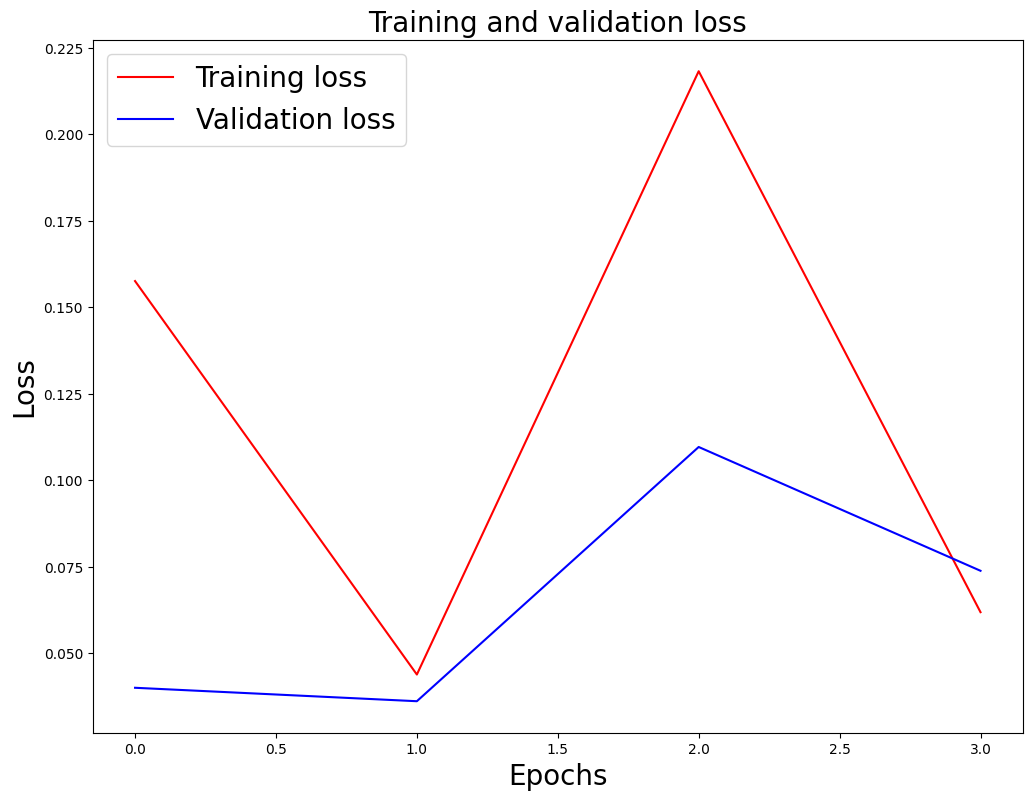

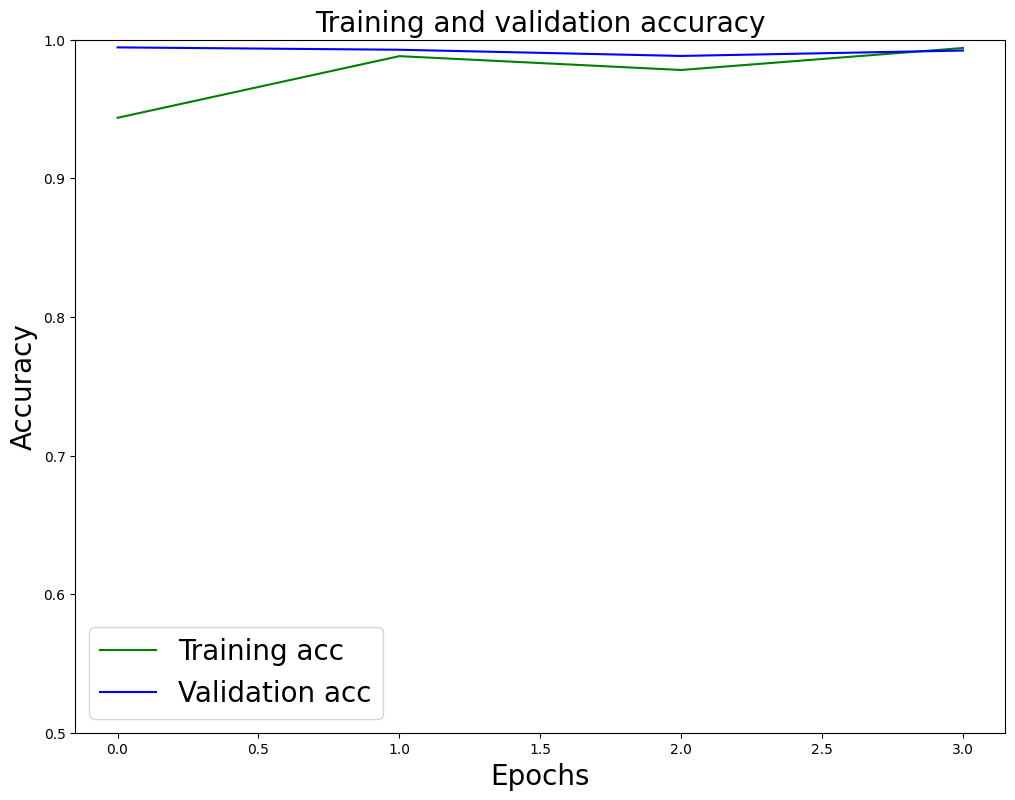

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [20]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 14s 217ms/step - loss: 0.0244 - accuracy: 0.9938


[0.024422021582722664, 0.9938272833824158]

We achieved a 99% accuracy on the test set